# ADS5006 기계학습특론 
# 기말과제 : 부정맥 판별

## 이름: 김한비
## 소속: 데이터사이언스융합과
## 학번: 2021712203

# 라이브러리 로드

In [149]:
from os import listdir
from os.path import isfile, join
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
from tensorflow import keras

In [2]:
# train E/ train NoE/ Test T 가있는, 데이터셋 경로지정
mypath = 'Dataset/'

# 데이터 불러오기

- XML 데이터를 불러오고 이를 DataFrame에 저장한다.
- df = No VF/VT train 으로 저장한다.
- df1 = VF/VT train 으로 저장한다.
- 최종적으로 df에 df와 df1을 같이 저장한다.

In [92]:
df = pd.DataFrame({'patientID':[],'Gender':[],'Age':[],'HeartRate':[],
                   'PRInterval':[],'RRInterval':[],'QRSDuration':[],'QTInterval'  : [],
                   'QTCorrected' : [],'PAxis' : [],'RAxis' : [],'TAxis' : []})

onlyfiles = [f for f in listdir(mypath+'Train_NoE/') if isfile(join(mypath+'Train_NoE/', f))]

for i in onlyfiles:
    tree = ET.parse(mypath +'Train_NoE/' + i)
    root = tree.getroot()
    patientID = (i.split('(')[1].split(')')[0])
    for child in root[1]:
        if child.tag == 'Gender':
            if child.text == 'Male':
                Gender = 0
            elif child.text == "Female":
                Gender = 1
        elif child.tag == 'Age':
            Age = int(child.text)
    for child in root[4]:
        if child.tag == 'HeartRate':
            HeartRate = int(child.text)
        elif child.tag == 'PRInterval':
            PRInterval = child.text
        elif child.tag == 'RRInterval':
            RRInterval = child.text
        elif child.tag == 'QRSDuration':
            QRSDuration = int(child.text)
        elif child.tag == 'QTInterval':
            QTInterval = int(child.text)
        elif child.tag == 'QTCorrected':
            QTCorrected = int(child.text)
        elif child.tag == 'PAxis':
            PAxis = child.text
        elif child.tag == 'RAxis':
            RAxis = int(child.text)
        elif child.tag == 'TAxis':
            TAxis = child.text

            
    df = df.append({'patientID':patientID,'Gender': Gender,'Age': Age, 'HeartRate': HeartRate,
                    'PRInterval':PRInterval ,'RRInterval':RRInterval,'QRSDuration':QRSDuration,'QTInterval'  : QTInterval,
                   'QTCorrected' : QTCorrected,'PAxis' :PAxis,'RAxis' :RAxis,'TAxis' :TAxis}, ignore_index=True)
        
df['labels'] = np.zeros(len(df))
df.head(5)

,patientID,Gender,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,1,0.0,68.0,50.0,220,None,100.0,469.0,428.0,30,63.0,106,0.0
1,10,0.0,59.0,62.0,191,968,97.0,433.0,440.0,54,-53.0,27,0.0
2,100,0.0,49.0,49.0,176,None,88.0,516.0,466.0,23,55.0,258,0.0
3,101,0.0,58.0,63.0,174,952,129.0,448.0,459.0,34,52.0,194,0.0
4,102,0.0,49.0,67.0,176,896,96.0,396.0,418.0,56,194.0,49,0.0


In [93]:
df1 = pd.DataFrame({'patientID':[],'Gender':[],'Age':[],'HeartRate':[],
                   'PRInterval':[],'RRInterval':[],'QRSDuration':[],'QTInterval'  : [],
                   'QTCorrected' : [],'PAxis' : [],'RAxis' : [],'TAxis' : []})

onlyfiles = [f for f in listdir(mypath+'Train_E/') if isfile(join(mypath+'Train_E/', f))]

for i in onlyfiles:
    tree = ET.parse(mypath+'Train_E/' + i)
    root = tree.getroot()
    patientID = (i.split('(')[1].split(')')[0])
    for child in root[1]:
        if child.tag == 'Gender':
            if child.text == 'Male':
                Gender = 0
            elif child.text == "Female":
                Gender = 1
        elif child.tag == 'Age':
            Age = int(child.text)
    for child in root[4]:
        if child.tag == 'HeartRate':
            HeartRate = int(child.text)
        elif child.tag == 'PRInterval':
            PRInterval = child.text
        elif child.tag == 'RRInterval':
            RRInterval = child.text
        elif child.tag == 'QRSDuration':
            QRSDuration = int(child.text)
        elif child.tag == 'QTInterval':
            QTInterval = int(child.text)
        elif child.tag == 'QTCorrected':
            QTCorrected = int(child.text)
        elif child.tag == 'PAxis':
            PAxis = child.text
        elif child.tag == 'RAxis':
            RAxis = int(child.text)
        elif child.tag == 'TAxis':
            TAxis = child.text
            
    df1 = df1.append({'patientID':patientID,'Gender': Gender,'Age': Age, 'HeartRate': HeartRate,
                    'PRInterval':PRInterval ,'RRInterval':RRInterval,'QRSDuration':QRSDuration,'QTInterval'  : QTInterval,
                   'QTCorrected' : QTCorrected,'PAxis' :PAxis,'RAxis' :RAxis,'TAxis' :TAxis}, ignore_index=True)
        
df1['labels'] = np.ones(len(df1))
df1.head(5)

,patientID,Gender,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,1,0.0,61.0,61.0,196,None,91.0,476.0,479.0,28,62.0,178,1.0
1,10,0.0,47.0,61.0,208,984,95.0,444.0,447.0,50,31.0,None,1.0
2,11,0.0,47.0,52.0,220,1152,94.0,500.0,465.0,43,19.0,-75,1.0
3,12,0.0,47.0,53.0,224,1132,100.0,476.0,447.0,48,19.0,-67,1.0
4,13,0.0,49.0,53.0,None,1132,108.0,448.0,421.0,None,-1.0,-83,1.0


In [94]:
# 데이터를 합치고 인덱스 초기화
df = [df,df1]
df = pd.concat(df)
df.reset_index(inplace=True,drop=True)

In [95]:
# 최종 데이터셋 확인
df.head(5)

,patientID,Gender,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,1,0.0,68.0,50.0,220,None,100.0,469.0,428.0,30,63.0,106,0.0
1,10,0.0,59.0,62.0,191,968,97.0,433.0,440.0,54,-53.0,27,0.0
2,100,0.0,49.0,49.0,176,None,88.0,516.0,466.0,23,55.0,258,0.0
3,101,0.0,58.0,63.0,174,952,129.0,448.0,459.0,34,52.0,194,0.0
4,102,0.0,49.0,67.0,176,896,96.0,396.0,418.0,56,194.0,49,0.0


In [96]:
# 'PAxis','TAxis' 에 포함된 Indeterminate와 failed는 결측치 처리하여 후에 따로 처리
for i in range(len(df)):
    if df['PAxis'].loc[i] == 'Indeterminate':
        df['PAxis'].loc[i] = None
    elif df['PAxis'].loc[i] == 'Failed':
        df['PAxis'].loc[i] = None
    if df['TAxis'].loc[i] == 'Failed':
        df['TAxis'].loc[i] = None      
    if df['PRInterval'].loc[i] == 'Failed':
        df['PRInterval'].loc[i] = None 

## Fig2. VF/VT가 있는 환자와 없는 환자의 12개 ECG leads wave 비교를 위한 시각화

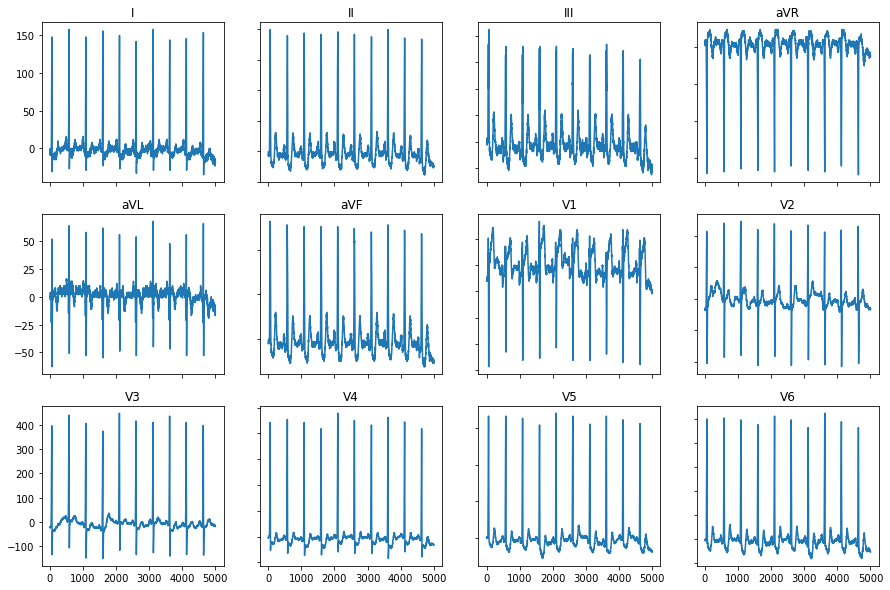

In [281]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))
tree = ET.parse('Dataset/Train_E/Train_E (3).XML')
root = tree.getroot()
dfn = pd.DataFrame()

for n in range(12):
    data = root[5][n + 5][10].text
    data = data.split(',')
    for i in range(len(data)):
        data[i] = int(data[i])
        dfn[root[5][n + 5][0].text] = data


for n in range(12):
    axs[n//4, n%4].plot(dfn[dfn.columns[n]])
    axs[n//4, n%4].set_title((dfn.columns[n]))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

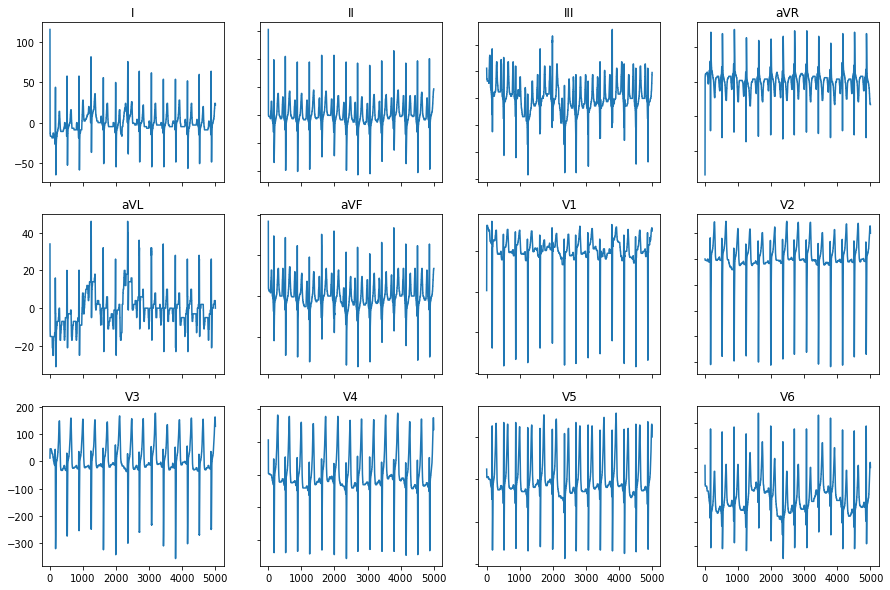

In [282]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))
tree = ET.parse('Dataset/Train_NoE/Train_NoE (4).XML')
root = tree.getroot()
dfn = pd.DataFrame()

for n in range(12):
    data = root[5][n + 5][10].text
    data = data.split(',')
    for i in range(len(data)):
        data[i] = int(data[i])
        dfn[root[5][n + 5][0].text] = data


for n in range(12):
    axs[n//4, n%4].plot(dfn[dfn.columns[n]])
    axs[n//4, n%4].set_title((dfn.columns[n]))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# 결측치 확인 및 처리

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patientID    646 non-null    object 
 1   Gender       646 non-null    float64
 2   Age          646 non-null    float64
 3   HeartRate    646 non-null    float64
 4   PRInterval   578 non-null    object 
 5   RRInterval   553 non-null    object 
 6   QRSDuration  646 non-null    float64
 7   QTInterval   646 non-null    float64
 8   QTCorrected  646 non-null    float64
 9   PAxis        575 non-null    object 
 10  RAxis        646 non-null    float64
 11  TAxis        633 non-null    object 
 12  labels       646 non-null    float64
dtypes: float64(8), object(5)
memory usage: 65.7+ KB


In [98]:
# Null 값이 존재하는 컬럼 확인
null_columns=df.columns[df.isnull().any()]
null_columns

Index(['PRInterval', 'RRInterval', 'PAxis', 'TAxis'], dtype='object')

In [99]:
# 결측치를 우선 제거 후 확인 
df_dropna = df.dropna()
df_dropna = df_dropna.iloc[:,2:].astype(int)
df_dropna.tail(5)

,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
639,73,59,224,1016,94,508,504,45,66,89,1
641,47,61,248,984,178,484,488,67,129,-34,1
643,72,58,138,1036,93,488,480,70,71,188,1
644,73,67,150,896,98,457,483,48,59,148,1
645,73,58,144,1036,98,484,476,62,70,187,1


## Fig 3 상관관계 분석표

In [100]:
# 상관관계 계수를 확인
corr = df_dropna.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
Age,1.000000,-0.022472,0.118032,0.055326,0.040896,0.119865,0.118729,-0.050361,-0.147083,0.066201,-0.082939
HeartRate,-0.022472,1.000000,-0.055401,-0.950868,-0.142119,-0.732370,0.240233,0.076713,-0.094085,0.033540,-0.151526
PRInterval,0.118032,-0.055401,1.000000,0.096187,0.143072,0.104351,0.045874,-0.095006,-0.053222,0.013128,0.170010
RRInterval,0.055326,-0.950868,0.096187,1.000000,0.127914,0.761865,-0.212373,-0.105383,0.100282,-0.050146,0.166491
QRSDuration,0.040896,-0.142119,0.143072,0.127914,1.000000,0.263608,0.222171,-0.000875,-0.110111,-0.037835,0.117095
QTInterval,0.119865,-0.732370,0.104351,0.761865,0.263608,1.000000,0.459580,-0.100722,0.025341,0.011749,0.207803
QTCorrected,0.118729,0.240233,0.045874,-0.212373,0.222171,0.459580,1.000000,-0.022266,-0.097184,0.067666,0.084989
PAxis,-0.050361,0.076713,-0.095006,-0.105383,-0.000875,-0.100722,-0.022266,1.000000,0.106982,0.015522,0.017918
RAxis,-0.147083,-0.094085,-0.053222,0.100282,-0.110111,0.025341,-0.097184,0.106982,1.000000,-0.045171,0.003591
TAxis,0.066201,0.033540,0.013128,-0.050146,-0.037835,0.011749,0.067666,0.015522,-0.045171,1.000000,-0.105839


In [101]:
df = df[['Age', 'HeartRate', 'PRInterval', 'QRSDuration','QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'labels']]
df.dropna(inplace=True)
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 645
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Age          566 non-null    int32
 1   HeartRate    566 non-null    int32
 2   PRInterval   566 non-null    int32
 3   QRSDuration  566 non-null    int32
 4   QTInterval   566 non-null    int32
 5   QTCorrected  566 non-null    int32
 6   PAxis        566 non-null    int32
 7   RAxis        566 non-null    int32
 8   TAxis        566 non-null    int32
 9   labels       566 non-null    int32
dtypes: int32(10)
memory usage: 26.5 KB


In [102]:
from scipy import stats
z_scores = stats.zscore(df.iloc[:,:-1])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df.iloc[:,:-1] = df.iloc[:,:-1][filtered_entries]

In [103]:
df.dropna(inplace=True)
df

,Age,HeartRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,68.0,50.0,220.0,100.0,469.0,428.0,30.0,63.0,106.0,0.0
1,59.0,62.0,191.0,97.0,433.0,440.0,54.0,-53.0,27.0,0.0
2,49.0,49.0,176.0,88.0,516.0,466.0,23.0,55.0,258.0,0.0
3,58.0,63.0,174.0,129.0,448.0,459.0,34.0,52.0,194.0,0.0
5,84.0,61.0,204.0,92.0,480.0,484.0,27.0,11.0,124.0,0.0
...,...,...,...,...,...,...,...,...,...,...
639,73.0,59.0,224.0,94.0,508.0,504.0,45.0,66.0,89.0,1.0
642,62.0,94.0,128.0,90.0,388.0,486.0,55.0,51.0,177.0,1.0
643,72.0,58.0,138.0,93.0,488.0,480.0,70.0,71.0,188.0,1.0
644,73.0,67.0,150.0,98.0,457.0,483.0,48.0,59.0,148.0,1.0


# SMOTE 적용

In [104]:
X = df.iloc[:,:-1]
y = df['labels']
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0.0: 510, 1.0: 20})
Counter({0.0: 510, 1.0: 510})


# RandomForestClassifier

In [105]:
# 트레인 / 테스트 셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4)

In [106]:
from sklearn.ensemble import RandomForestClassifier
RFclf = RandomForestClassifier(max_depth=5, random_state=0)
RFclf.fit(X_train, y_train)
scores = RFclf.score(X_test, y_test)
print("Random Forest Classifier Accuracy : ",scores)

Random Forest Classifier Accuracy :  0.9313725490196079


In [107]:
scoring = ['accuracy', 'f1']
scores = cross_validate(RFclf, X, y, scoring=scoring, cv=5)
print("Random Forest CV")
for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])

Random Forest CV
Accuracy :  0.946078431372549   F1 :  0.9458128078817734
Accuracy :  0.9558823529411765   F1 :  0.9565217391304348
Accuracy :  0.9705882352941176   F1 :  0.970873786407767
Accuracy :  0.8774509803921569   F1 :  0.8730964467005077
Accuracy :  0.9068627450980392   F1 :  0.9107981220657277


# Test 

In [73]:
onlyfiles = [f for f in listdir(mypath+'Test_E/') if isfile(join(mypath+'Test_E/', f))]

test1 = []
test2 = []
test3 = []
for i in onlyfiles:
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    if root[2].tag == "StudyInfo":
        test1.append(i)
    elif root[2].tag == "OrderInfo":
        test2.append(i)
    else:
        test3.append(i)

In [110]:
df_test = pd.DataFrame({'patientID':[],'Gender':[],'Age':[],'HeartRate':[],
                   'PRInterval':[],'RRInterval':[],'QRSDuration':[],'QTInterval'  : [],
                   'QTCorrected' : [],'PAxis' : [],'RAxis' : [],'TAxis' : []})


for i in test2:
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    patientID = (i.split('(')[1].split(')')[0])
    for child in root[1]:
        if child.tag == 'Gender':
            if child.text == 'Male':
                Gender = 0
            elif child.text == "Female":
                Gender = 1
        elif child.tag == 'Age':
            Age = child.text
    for child in root[4]:
        if child.tag == 'HeartRate':
            HeartRate = int(child.text)
        elif child.tag == 'PRInterval':
            PRInterval = child.text
        elif child.tag == 'RRInterval':
            RRInterval = child.text
        elif child.tag == 'QRSDuration':
            QRSDuration = int(child.text)
        elif child.tag == 'QTInterval':
            QTInterval = int(child.text)
        elif child.tag == 'QTCorrected':
            QTCorrected = int(child.text)
        elif child.tag == 'PAxis':
            PAxis = child.text
        elif child.tag == 'RAxis':
            RAxis = int(child.text)
        elif child.tag == 'TAxis':
            TAxis = child.text

            
    df_test = df_test.append({'patientID':patientID,'Gender': Gender,'Age': Age, 'HeartRate': HeartRate,
                    'PRInterval':PRInterval ,'RRInterval':RRInterval,'QRSDuration':QRSDuration,'QTInterval'  : QTInterval,
                   'QTCorrected' : QTCorrected,'PAxis' :PAxis,'RAxis' :RAxis,'TAxis' :TAxis}, ignore_index=True)
        
df_test['labels'] = np.ones(len(df_test))
df_test.head(5)

,patientID,Gender,Age,HeartRate,PRInterval,RRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,10,1.0,72,88.0,None,680,87.0,340.0,412.0,None,50.0,180,1.0
1,18,0.0,58,57.0,168,1052,121.0,472.0,460.0,42,43.0,181,1.0
2,241,0.0,60,93.0,180,644,90.0,356.0,443.0,38,52.0,129,1.0
3,242,0.0,75,82.0,128,732,120.0,384.0,449.0,68,46.0,127,1.0
4,243,1.0,39,65.0,164,924,86.0,412.0,429.0,62,-36.0,120,1.0


In [111]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patientID    60 non-null     object 
 1   Gender       60 non-null     float64
 2   Age          46 non-null     object 
 3   HeartRate    60 non-null     float64
 4   PRInterval   55 non-null     object 
 5   RRInterval   60 non-null     object 
 6   QRSDuration  60 non-null     float64
 7   QTInterval   60 non-null     float64
 8   QTCorrected  60 non-null     float64
 9   PAxis        54 non-null     object 
 10  RAxis        60 non-null     float64
 11  TAxis        58 non-null     object 
 12  labels       60 non-null     float64
dtypes: float64(7), object(6)
memory usage: 6.2+ KB


In [112]:
df_test = df_test[['Age', 'HeartRate', 'PRInterval', 'QRSDuration','QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'labels']]

In [113]:
df_test.dropna(inplace=True)

In [114]:
RFclf.predict(df_test.iloc[:,:-1])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0.])

In [115]:
scores = RFclf.score(df_test.iloc[:,:-1], df_test.labels)
print("Random Forest Classifier TEST Accuracy : ",scores)

Random Forest Classifier TEST Accuracy :  0.15384615384615385


In [17]:
# RRInterval은 결측지가 다수 존재하며, HeartRate와 QTInterval과의 상관관계가 높음으로 대체될수있다 판단 
df = df.drop('RRInterval',axis=1)
df

,patientID,Gender,Age,HeartRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,labels
0,1,0.0,68.0,50.0,220,100.0,469.0,428.0,30,63.0,106,0.0
1,10,0.0,59.0,62.0,191,97.0,433.0,440.0,54,-53.0,27,0.0
2,100,0.0,49.0,49.0,176,88.0,516.0,466.0,23,55.0,258,0.0
3,101,0.0,58.0,63.0,174,129.0,448.0,459.0,34,52.0,194,0.0
4,102,0.0,49.0,67.0,176,96.0,396.0,418.0,56,194.0,49,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
641,5,1.0,47.0,61.0,248,178.0,484.0,488.0,67,129.0,-34,1.0
642,6,1.0,62.0,94.0,128,90.0,388.0,486.0,55,51.0,177,1.0
643,7,1.0,72.0,58.0,138,93.0,488.0,480.0,70,71.0,188,1.0
644,8,1.0,73.0,67.0,150,98.0,457.0,483.0,48,59.0,148,1.0


In [18]:
# 결측치 갯수 확인
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

PRInterval    68
PAxis         71
TAxis         13
dtype: int64

In [288]:
df_PR = df.dropna()
df_PR = df_PR[['Gender', 'Age', 'HeartRate', 'QRSDuration','TAxis',
       'QTInterval', 'QTCorrected', 'RAxis', 'labels', 'PRInterval']]

In [289]:
# 현재 모든 값들이 object로 되어있음
df_PR.reset_index(inplace=True,drop=True)
df_PR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       566 non-null    object 
 1   Age          566 non-null    object 
 2   HeartRate    566 non-null    object 
 3   QRSDuration  566 non-null    object 
 4   TAxis        566 non-null    object 
 5   QTInterval   566 non-null    object 
 6   QTCorrected  566 non-null    object 
 7   RAxis        566 non-null    object 
 8   labels       566 non-null    float64
 9   PRInterval   566 non-null    object 
dtypes: float64(1), object(9)
memory usage: 44.3+ KB


In [290]:
# 정수화
df_PR = df_PR.astype(int)
df_PR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Gender       566 non-null    int32
 1   Age          566 non-null    int32
 2   HeartRate    566 non-null    int32
 3   QRSDuration  566 non-null    int32
 4   TAxis        566 non-null    int32
 5   QTInterval   566 non-null    int32
 6   QTCorrected  566 non-null    int32
 7   RAxis        566 non-null    int32
 8   labels       566 non-null    int32
 9   PRInterval   566 non-null    int32
dtypes: int32(10)
memory usage: 22.2 KB


## 결측치를 회귀식으로 구하는 것과 평균으로 구했을 때를 비교.

### PRInterval 결측치

In [291]:
# 트레인/테스트셋 나누기 0.3비율
X_train, X_test, y_train, y_test = train_test_split(df_PR.iloc[:,:-1], df_PR['PRInterval'], 
                                                    test_size=0.3, random_state=42)

In [292]:
# 랜덤포레스트리그레서 사용
regr_PR = RandomForestRegressor(max_depth=50, random_state=0)
regr_PR.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=0)

In [293]:
# 평균으로 결측치를 대체 했을때
y_pred = [np.mean(df_PR['PRInterval'])] * len(y_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 23.111702348784032
Mean Squared Error: 951.7165239333008
Root Mean Squared Error: 30.849903143013282


In [294]:
# 랜덤포레스트리그레서로 대체 했을때,
y_pred = regr_PR.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 19.95041176470588
Mean Squared Error: 759.5421523529412
Root Mean Squared Error: 27.559792313312908


In [295]:
df_PR['PRInterval'].describe()

count    566.000000
mean     174.061837
std       29.776894
min      108.000000
25%      155.000000
50%      171.000000
75%      191.000000
max      404.000000
Name: PRInterval, dtype: float64

### 결론: 
 PRInterval의 결측치의 경우, 평균으로 대체하는 것보다 RandomForestRegressor를 사용하여 예측한 값을 사용 했을때, 에러가 줄어든다는 것을 입증함.

### PAxis 결측치

In [296]:
# 앞선 PRInterval과 동일
df_PA = df.dropna()
df_PA = df_PA[['Gender', 'Age', 'HeartRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'labels', 'PRInterval', 'PAxis']]
df_PA.reset_index(inplace=True,drop=True)
df_PA = df_PA.astype(int)

In [297]:
# 트레인/테스트셋 나누기 0.3비율
X_train, X_test, y_train, y_test = train_test_split(df_PA.iloc[:,:-1], df_PA['PAxis'], 
                                                    test_size=0.3, random_state=42)

In [298]:
# 랜덤포레스트리그레서 사용
regr_PA = RandomForestRegressor(max_depth=50, random_state=0)
regr_PA.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=0)

In [299]:
# 평균으로 결측치를 대체 했을때
y_pred = [np.mean(df_PA['PAxis'])] * len(y_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 21.52772812305134
Mean Squared Error: 764.1988261955632
Root Mean Squared Error: 27.64414632784965


In [300]:
# 랜덤포레스트리그레서로 대체 했을때,
y_pred = regr_PA.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 21.299411764705884
Mean Squared Error: 799.4170329411764
Root Mean Squared Error: 28.273963870337962


In [301]:
df_PA['PAxis'].describe()

count    566.000000
mean      41.330389
std       28.278301
min      -90.000000
25%       25.000000
50%       48.000000
75%       62.000000
max      143.000000
Name: PAxis, dtype: float64

### 결론: 
 PAxis의 결측치의 경우, 평균으로 대체하는 것보다 RandomForestRegressor를 사용하여 예측한 값을 사용 했을때, 에러가 줄어든다는 것을 입증함.

### TAxis 결측치

In [302]:
# 앞선 PRInterval과 동일
df_TA = df.dropna()
df_TA = df_TA[['Gender', 'Age', 'HeartRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'labels', 'TAxis']]
df_TA.reset_index(inplace=True,drop=True)
df_TA = df_TA.astype(int)

In [303]:
# 트레인/테스트셋 나누기 0.3비율
X_train, X_test, y_train, y_test = train_test_split(df_TA.iloc[:,:-1], df_TA['TAxis'], 
                                                    test_size=0.3, random_state=42)

In [304]:
# 랜덤포레스트리그레서 사용
regr_TA = RandomForestRegressor(max_depth=50, random_state=0)
regr_TA.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=0)

In [305]:
# 평균으로 결측치를 대체 했을때
y_pred = [np.mean(df_PA['PAxis'])] * len(y_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 94.59997921430056
Mean Squared Error: 12123.78818391745
Root Mean Squared Error: 110.10807501685537


In [306]:
# 랜덤포레스트리그레서로 대체 했을때,
y_pred = regr_TA.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 59.17064705882354
Mean Squared Error: 6026.604513529412
Root Mean Squared Error: 77.63120837349766


In [307]:
df_TA['TAxis'].describe()

count    566.000000
mean     114.545936
std       80.361488
min      -87.000000
25%       64.250000
50%      124.000000
75%      169.750000
max      268.000000
Name: TAxis, dtype: float64

### 결론: 
 TAxis의 결측치의 경우, 평균으로 대체하는 것보다 RandomForestRegressor를 사용하여 예측한 값을 사용 했을때, 에러가 줄어든다는 것을 입증함. 앞선 PRInterval과 PAxis에 비해 에러가 크지만, RMSE가 std보다 크지 않기 때문에 사용하여도 괜찮다고 판단.

## 결측치 채우기

결측치의 경우, 두개가 동시에 없는 경우가 많았기 하나의 결측치를 먼저 예측하고 예측된 값을 추가하여 다음 결측치를 찾게 함.
따라서, 위에 테스트 환경에서 바꿔본 결과
TAxis -> PRInterval -> PAxis 순으로 결측치를 채우는 것이 가장 효율적이라고 판단.

In [308]:
for i in range(len(df)):
    if df['TAxis'].loc[i] == None:
        df['TAxis'].loc[i] = regr_TA.predict((np.array(df[['Gender', 'Age', 'HeartRate', 'QRSDuration',
                                                 'QTInterval', 'QTCorrected', 'RAxis', 'labels']].loc[i])).reshape(1, -1))

In [309]:
for i in range(len(df)):
    if df['PRInterval'].loc[i] == None:
        df['PRInterval'].loc[i] = regr_PR.predict((np.array(df[['Gender', 'Age', 'HeartRate', 'QRSDuration','TAxis',
       'QTInterval', 'QTCorrected', 'RAxis', 'labels']].loc[i])).reshape(1,-1))

In [310]:
for i in range(len(df)):
    if df['PAxis'].loc[i] == None:
        df['PAxis'].loc[i] = regr_PA.predict((np.array(df[['Gender', 'Age', 'HeartRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'labels', 'PRInterval']].loc[i])).reshape(1,-1))

In [311]:
# 최종 df 확인
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   patientID    646 non-null    int32
 1   Gender       646 non-null    int32
 2   Age          646 non-null    int32
 3   HeartRate    646 non-null    int32
 4   PRInterval   646 non-null    int32
 5   QRSDuration  646 non-null    int32
 6   QTInterval   646 non-null    int32
 7   QTCorrected  646 non-null    int32
 8   PAxis        646 non-null    int32
 9   RAxis        646 non-null    int32
 10  TAxis        646 non-null    int32
 11  labels       646 non-null    int32
dtypes: int32(12)
memory usage: 30.4 KB


In [312]:
X = df.iloc[:,1:-1]
y = df['labels']
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0: 619, 1: 27})
Counter({0: 619, 1: 619})


In [313]:
# 전체적으로 이상치 등을 확인
X.describe()

,Gender,Age,HeartRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000
mean,0.243134,57.491922,63.987884,186.050889,106.489499,445.869144,456.625202,43.332795,36.777060,95.642973
std,0.429149,11.735478,11.424449,31.181397,20.647509,41.019592,30.126010,22.073642,41.807799,92.140091
min,0.000000,16.000000,37.000000,0.000000,66.000000,260.000000,315.000000,-90.000000,-177.000000,-87.000000
25%,0.000000,49.000000,57.000000,164.000000,92.000000,416.000000,436.000000,34.000000,11.250000,33.000000
50%,0.000000,57.000000,61.000000,188.000000,100.000000,450.000000,456.500000,47.000000,43.000000,114.500000
75%,0.000000,66.000000,69.000000,209.000000,116.000000,474.000000,477.000000,57.000000,63.000000,163.000000
max,1.000000,88.000000,159.000000,404.000000,204.000000,572.000000,636.000000,143.000000,258.000000,268.000000


In [314]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1233    1
1234    1
1235    1
1236    1
1237    1
Name: labels, Length: 1238, dtype: int32

# 머신러닝 알고리즘 적용

In [315]:
# 트레인 / 테스트 셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4)

## Logistic regression

In [316]:
# Logstic Regression 적용 후 Scoring 측정
from sklearn.linear_model import LogisticRegression
LRclf = LogisticRegression(random_state=0)
LRclf.fit(X_train, y_train)
scores = LRclf.score(X_test, y_test)
print("Logistic Regression Accuracy : ",scores)

Logistic Regression Accuracy :  0.7768817204301075


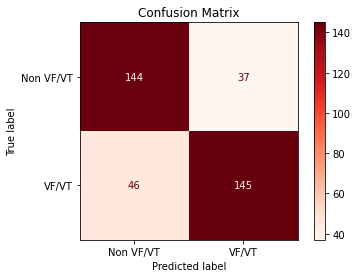

In [317]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion Matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(LRclf, X_test, y_test,
                                 display_labels=["Non VF/VT","VF/VT"],
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

## RandomForestClassifier

In [318]:
from sklearn.ensemble import RandomForestClassifier
RFclf = RandomForestClassifier(max_depth=5, random_state=0)
RFclf.fit(X_train, y_train)
scores = RFclf.score(X_test, y_test)
print("Random Forest Classifier Accuracy : ",scores)

Random Forest Classifier Accuracy :  0.9220430107526881


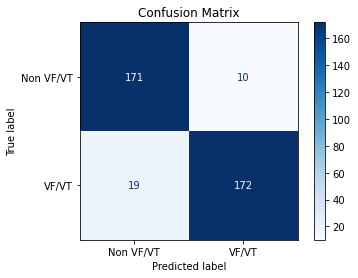

In [319]:
# Confusion Matrix
titles_options = [("Confusion Matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RFclf, X_test, y_test,
                                 display_labels=["Non VF/VT","VF/VT"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

# Cross-Validation

In [320]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy', 'f1']
scores = cross_validate(LRclf, X, y, scoring=scoring, cv=5)
print("Logistic Regression CV")
for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])


Logistic Regression CV
Accuracy :  0.782258064516129   F1 :  0.7822580645161291
Accuracy :  0.7782258064516129   F1 :  0.7755102040816327
Accuracy :  0.7983870967741935   F1 :  0.8076923076923077
Accuracy :  0.7692307692307693   F1 :  0.7764705882352942
Accuracy :  0.8178137651821862   F1 :  0.8235294117647058


In [321]:
scores = cross_validate(RFclf, X, y, scoring=scoring, cv=5)
print("Random Forest CV")
for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])

Random Forest CV
Accuracy :  0.9475806451612904   F1 :  0.946938775510204
Accuracy :  0.9274193548387096   F1 :  0.9274193548387096
Accuracy :  0.9354838709677419   F1 :  0.9344262295081968
Accuracy :  0.9149797570850202   F1 :  0.9163346613545816
Accuracy :  0.9271255060728745   F1 :  0.9291338582677167


## RandomForest Feature Importance

Feature: 0, Score: 0.00233
Feature: 1, Score: 0.09614
Feature: 2, Score: 0.06054
Feature: 3, Score: 0.24948
Feature: 4, Score: 0.13426
Feature: 5, Score: 0.21243
Feature: 6, Score: 0.07020
Feature: 7, Score: 0.06059
Feature: 8, Score: 0.05791
Feature: 9, Score: 0.05612


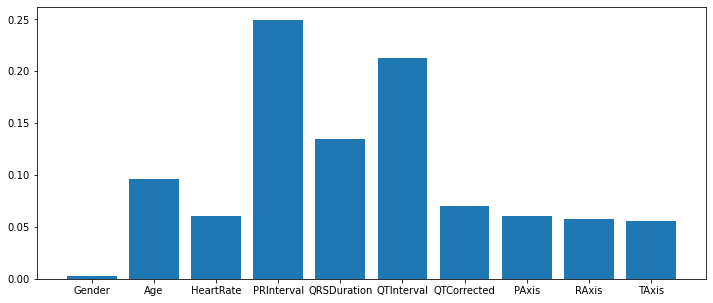

In [324]:
plt.figure(figsize=(12, 5))
importance = RFclf.fit(X_train, y_train).feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar(X.columns.to_list(), importance)
plt.show()

# Gender 변수 제거 후 RandomForest

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], y,test_size=0.3, random_state=4)
RF1clf = RandomForestClassifier(max_depth=5, random_state=0)
RF1clf.fit(X_train, y_train)
scores = RF1clf.score(X_test, y_test)
print("Gender 제거 후 Random Forest Classifier Accuracy ; ", scores)

Gender 제거 후 Random Forest Classifier Accuracy ;  0.9301075268817204


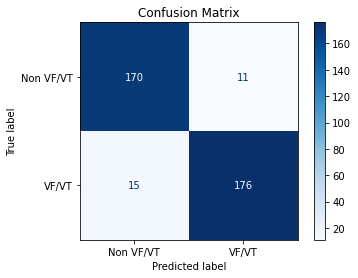

In [326]:
# Confusio Matrix
titles_options = [("Confusion Matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RF1clf, X_test, y_test,
                                 display_labels=["Non VF/VT","VF/VT"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [327]:
scores = cross_validate(RF1clf, X, y, scoring=scoring, cv=10)

for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])

Accuracy :  0.9354838709677419   F1 :  0.9344262295081968
Accuracy :  0.967741935483871   F1 :  0.9672131147540983
Accuracy :  0.9596774193548387   F1 :  0.9606299212598426
Accuracy :  0.9193548387096774   F1 :  0.9180327868852459
Accuracy :  0.9193548387096774   F1 :  0.9180327868852459
Accuracy :  0.9354838709677419   F1 :  0.9344262295081968
Accuracy :  0.9032258064516129   F1 :  0.9016393442622951
Accuracy :  0.9193548387096774   F1 :  0.921875
Accuracy :  0.9349593495934959   F1 :  0.9354838709677418
Accuracy :  0.9105691056910569   F1 :  0.912


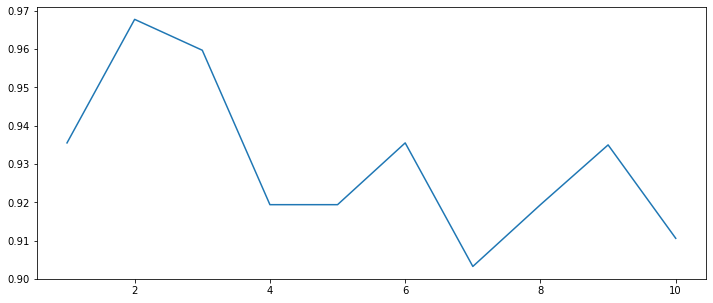

In [328]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
ax.plot(range(1,11),scores['test_accuracy'])

In [329]:
np.mean(scores['test_accuracy'])

0.9305205874639391

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], y,test_size=0.3, random_state=4)
RF1clf = RandomForestClassifier(max_depth=50, random_state=0)
RF1clf.fit(X_train, y_train)
scores = RF1clf.score(X_test, y_test)
print("Gender 제거 후 Random Forest Classifier Accuracy ; ", scores)

Gender 제거 후 Random Forest Classifier Accuracy ;  0.9543010752688172


In [331]:
scores = cross_validate(RF1clf, X, y, scoring=scoring, cv=10)

for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])

Accuracy :  0.967741935483871   F1 :  0.967741935483871
Accuracy :  0.9919354838709677   F1 :  0.991869918699187
Accuracy :  0.9838709677419355   F1 :  0.9838709677419355
Accuracy :  0.967741935483871   F1 :  0.967741935483871
Accuracy :  0.967741935483871   F1 :  0.967741935483871
Accuracy :  0.9758064516129032   F1 :  0.976
Accuracy :  0.9838709677419355   F1 :  0.9838709677419355
Accuracy :  0.9435483870967742   F1 :  0.9465648854961832
Accuracy :  0.967479674796748   F1 :  0.9672131147540983
Accuracy :  0.983739837398374   F1 :  0.9841269841269841


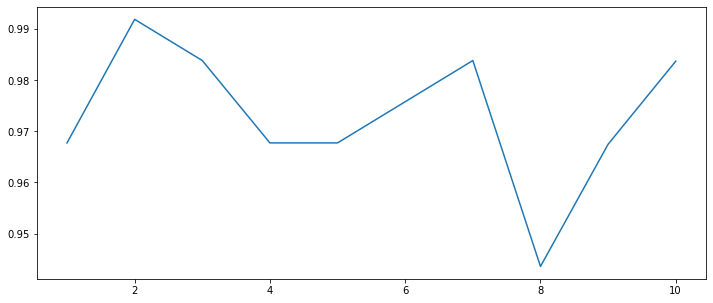

In [332]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
ax.plot(range(1,11),scores['test_accuracy'])

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], y,test_size=0.3, random_state=4)
LR1clf = LogisticRegression(random_state=0)
LR1clf.fit(X_train, y_train)
scores = LR1clf.score(X_test, y_test)
print("Logistic Regression Accuracy : ",scores)
scores = cross_validate(LR1clf, X, y, scoring=scoring, cv=10)

for i in range(len(scores['test_accuracy'])):
    print("Accuracy : ",scores['test_accuracy'][i],' ',"F1 : ",scores['test_f1'][i])

Logistic Regression Accuracy :  0.7768817204301075
Accuracy :  0.7661290322580645   F1 :  0.7642276422764228
Accuracy :  0.7903225806451613   F1 :  0.7903225806451614
Accuracy :  0.8145161290322581   F1 :  0.8067226890756302
Accuracy :  0.75   F1 :  0.752
Accuracy :  0.7661290322580645   F1 :  0.7716535433070866
Accuracy :  0.8387096774193549   F1 :  0.8507462686567164
Accuracy :  0.7983870967741935   F1 :  0.8062015503875968
Accuracy :  0.7338709677419355   F1 :  0.7441860465116278
Accuracy :  0.8536585365853658   F1 :  0.8571428571428572
Accuracy :  0.7642276422764228   F1 :  0.7642276422764228


## Fig4. Wave 이상치 데이터 확인

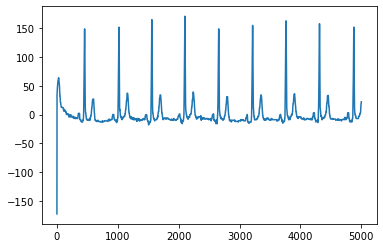

In [334]:
tree = ET.parse(mypath+'/Train_NoE/Train_NoE (200).XML')
root = tree.getroot()
data = root[5][10][10].text
data = data.split(',')
for i in range(len(data)):
    data[i] = int(data[i])
plt.plot(data)
plt.show()

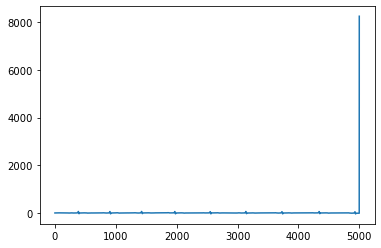

In [27]:
tree = ET.parse(mypath+'/Train_NoE/Train_NoE (201).XML')
root = tree.getroot()
data = root[5][10][10].text
data = data.split(',')
for i in range(len(data)):
    data[i] = int(data[i])
plt.plot(data)
plt.show()

# Wave Data 전처리


# Neural Network

In [116]:
onlyfiles = [f for f in listdir(mypath+'Train_E/') if isfile(join(mypath+'Train_E/', f))]
data_com = []
for i in onlyfiles:
    data_list = []
    tree = ET.parse(mypath +'Train_E/' + i)
    root = tree.getroot()
    for j in range(12):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))
    
onlyfiles = [f for f in listdir(mypath+'Train_NoE/') if isfile(join(mypath+'Train_NoE/', f))]
random.seed(10)
# for i in random.sample(onlyfiles,33):
for i in onlyfiles:
    tree = ET.parse(mypath +'Train_NoE/' + i)
    root = tree.getroot()
    data_list = []
    for j in range(12):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))
  

In [117]:
train = np.array(data_com)

In [118]:
train.shape

(646, 12, 4998)

In [119]:
train = train.reshape((646,12*4998))
train.shape

(646, 59976)

In [136]:

label_list = [0]*619
label_list1 = [1]*27

for i in label_list1 :
    label_list.append(i)

In [137]:
X = train
y = label_list
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0: 619, 1: 27})
Counter({0: 619, 1: 619})


In [138]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(label_list)


In [163]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels,test_size=0.3, random_state=4)

In [178]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(12*4998,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [179]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [180]:
EPOCHS = 20
history = model.fit(X_train,y_train,epochs=EPOCHS,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 7.5510 - accuracy: 0.2810 - val_loss: 2.5961 - val_accuracy: 0.9227
Epoch 2/20
1/1 [==============================] - 0s 229ms/step - loss: 1.8419 - accuracy: 0.9558 - val_loss: 2.3036 - val_accuracy: 0.9742
Epoch 3/20
1/1 [==============================] - 0s 263ms/step - loss: 1.5426 - accuracy: 0.9513 - val_loss: 2.5513 - val_accuracy: 0.9742
Epoch 4/20
1/1 [==============================] - 0s 254ms/step - loss: 1.5322 - accuracy: 0.9513 - val_loss: 3.0900 - val_accuracy: 0.9742
Epoch 5/20
1/1 [==============================] - 0s 240ms/step - loss: 0.7267 - accuracy: 0.9690 - val_loss: 3.5572 - val_accuracy: 0.9742
Epoch 6/20
1/1 [==============================] - 0s 258ms/step - loss: 0.3299 - accuracy: 0.9823 - val_loss: 3.8284 - val_accuracy: 0.9742
Epoch 7/20
1/1 [==============================] - 0s 226ms/step - loss: 0.0743 - accuracy: 0.9912 - val_loss: 3.9914 - val_accuracy: 0.9742
Epoch 8/20
1/1 [=======

In [181]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

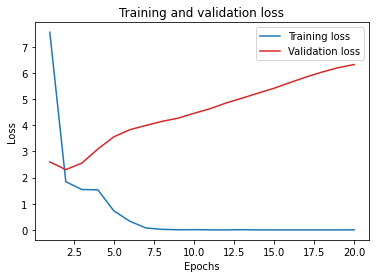

In [182]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss', color="tab:blue")
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color="tab:red")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

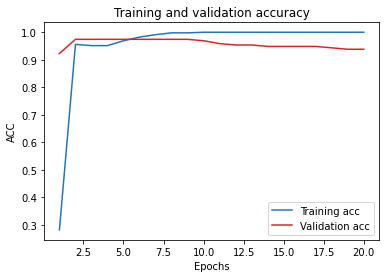

In [183]:
acc_values = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc', color="tab:blue")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="tab:red")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

# Test

In [216]:
data_com = []
for i in test1:
    data_list = []
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    for j in range(12):
        data = root[2][26+j][1][0].text
        data = data.split(' ')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [217]:
test = np.array(data_com)
test.shape

In [220]:
test = test.reshape((len(test),12*4998))
test.shape

(197, 59976)

In [223]:
model.predict_classes(test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [225]:
label_list = [1]* len(test)
test_labels = to_categorical(label_list)

In [226]:
model.evaluate(test,test_labels)

7/7 [==============================] - 0s 10ms/step - loss: 81.6401 - accuracy: 0.0660


[81.64008331298828, 0.06598984450101852]

# 결론:

 Neural Network를 사용하여 12개의 ECG Lead 데이터의 첫번째, 마지막 값을 제외한 4998개의 데이터를 사용한 결과, 훈련 상황에서 Accuracy와 Validation Accuracy 모두 0.9 보다 높았으나, 최종 테스트 단계에서는 0.1에도 미치지 못하였다. 

# 가설:
 ECG Lead 데이터 12개를 모두 사용하는 것은 데이터 양이 너무 많아 과적합이 일어날수 있으니, ECG Lead 한 개 만을 이용한 Neural Network 이용

In [227]:
onlyfiles = [f for f in listdir(mypath+'Train_E/') if isfile(join(mypath+'Train_E/', f))]
data_com = []
for i in onlyfiles:
    data_list = []
    tree = ET.parse(mypath +'Train_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))
    
onlyfiles = [f for f in listdir(mypath+'Train_NoE/') if isfile(join(mypath+'Train_NoE/', f))]
random.seed(10)
# for i in random.sample(onlyfiles,33):
for i in onlyfiles:
    tree = ET.parse(mypath +'Train_NoE/' + i)
    root = tree.getroot()
    data_list = []
    for j in range(1):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [228]:
train = np.array(data_com)

In [229]:
# 첫번째 Lead 만 사용함으로 shape가 1로 바뀐것을 볼수있다.
train.shape

(646, 1, 4998)

In [230]:
train = train.reshape((646,1*4998))
train.shape

(646, 4998)

In [231]:
label_list = [1]*27
label_list1 = [0]*619

for i in label_list1 :
    label_list.append(i)

In [232]:
X = train
y = label_list
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0: 619, 1: 27})
Counter({1: 619, 0: 619})


In [233]:
train_labels = to_categorical(label_list)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels,test_size=0.3, random_state=4)

In [260]:
# 모델의 처음 Input Shape 변경
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(1*4998,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [261]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [269]:
history = model.fit(X_train,y_train,epochs=5,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/5
1/1 [==============================] - 0s 73ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.2602 - val_accuracy: 0.9536
Epoch 2/5
1/1 [==============================] - 0s 45ms/step - loss: 7.8600e-04 - accuracy: 1.0000 - val_loss: 1.2576 - val_accuracy: 0.9536
Epoch 3/5
1/1 [==============================] - 0s 47ms/step - loss: 6.3809e-04 - accuracy: 1.0000 - val_loss: 1.2555 - val_accuracy: 0.9485
Epoch 4/5
1/1 [==============================] - 0s 41ms/step - loss: 5.5038e-04 - accuracy: 1.0000 - val_loss: 1.2544 - val_accuracy: 0.9485
Epoch 5/5
1/1 [==============================] - 0s 46ms/step - loss: 4.8823e-04 - accuracy: 1.0000 - val_loss: 1.2544 - val_accuracy: 0.9485


In [270]:
data_com = []
for i in test1:
    data_list = []
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[2][26+j][1][0].text
        data = data.split(' ')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [271]:
test = np.array(data_com)
test.shape

(197, 1, 4998)

In [272]:
test = test.reshape((len(test),1*4998))
test.shape

(197, 4998)

In [273]:
model.predict_classes(test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [274]:
label_list = [1]* len(test)
test_labels = to_categorical(label_list)

In [275]:
model.evaluate(test,test_labels)

7/7 [==============================] - 0s 2ms/step - loss: 18.4225 - accuracy: 0.0000e+00


[18.422494888305664, 0.0]

# 결론: 

Accuracy가 줄었으나, Loss가 많이 줄었음으로 Lead를 줄이는 방법이 효율적이라 판단

# 가설:

VT/VF가 있고 없고의 판단은 그래프의 주기 및 패턴에 따라 달라지기 때문에, 정규화를 통해서 숫자를 통일 시켜서 과적합을 줄이는 시도

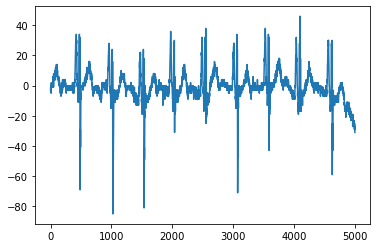

In [281]:
tree = ET.parse(mypath+'/Train_NoE/Train_NoE (21).XML')
root = tree.getroot()
data = root[5][10][10].text
data = data.split(',')
for i in range(len(data)):
    data[i] = int(data[i])
plt.plot(data)
plt.show()

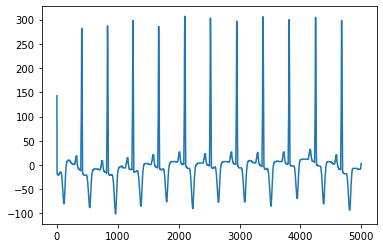

In [282]:
tree = ET.parse(mypath+'/Train_NoE/Train_NoE (22).XML')
root = tree.getroot()
data = root[5][10][10].text
data = data.split(',')
for i in range(len(data)):
    data[i] = int(data[i])
plt.plot(data)
plt.show()

In [283]:
onlyfiles = [f for f in listdir(mypath+'Train_E/') if isfile(join(mypath+'Train_E/', f))]
data_com = []
for i in onlyfiles:
    data_list = []
    tree = ET.parse(mypath +'Train_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))
    
onlyfiles = [f for f in listdir(mypath+'Train_NoE/') if isfile(join(mypath+'Train_NoE/', f))]
random.seed(10)
# for i in random.sample(onlyfiles,33):
for i in onlyfiles:
    tree = ET.parse(mypath +'Train_NoE/' + i)
    root = tree.getroot()
    data_list = []
    for j in range(1):
        data = root[5][j+5][10].text
        data = data.split(',')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [285]:
# 첫번째 Lead 만 사용함으로 shape가 1로 바뀐것을 볼수있다.
train = np.array(data_com)
train.shape

(646, 1, 4998)

In [286]:
train = train.reshape((646,1*4998))
train.shape

(646, 4998)

In [287]:
train[0]

array([ 0, -1, -1, ...,  0,  0,  0])

In [291]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train)
X_scaled = scaler.transform(train)
X_scaled

array([[-6.73668293e-02, -4.67892110e-02, -3.06420453e-02, ...,
         1.21867025e-01,  1.13828725e-01,  1.11493648e-01],
       [ 6.05740408e-01,  9.12349487e-01,  1.01791766e+00, ...,
        -6.04656584e-01, -6.53031307e-01, -7.04413385e-01],
       [-1.45033049e-01, -4.67892110e-02, -5.06741835e-03, ...,
        -7.20900362e-01, -8.23444647e-01, -8.16952286e-01],
       ...,
       [-1.05113895e+00, -1.13554125e+00, -1.15592563e+00, ...,
         2.09049858e-01,  1.99035395e-01,  1.95897824e-01],
       [ 1.13854350e-01,  1.34669462e-01,  1.22805717e-01, ...,
         5.62324775e-03,  2.19831450e-04, -1.04525295e-03],
       [-1.55893496e-02, -7.27118785e-02, -8.17912993e-02, ...,
        -7.20900362e-01, -7.09835754e-01, -7.04413385e-01]])

In [294]:
X_scaled[0]

array([-0.06736683, -0.04678921, -0.03064205, ...,  0.12186703,
        0.11382873,  0.11149365])

In [ ]:
label_list = [1]*27
label_list1 = [0]*619

for i in label_list1 :
    label_list.append(i)

In [296]:
X = X_scaled
y = label_list
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0: 619, 1: 27})
Counter({1: 619, 0: 619})


In [297]:

train_labels = to_categorical(label_list)

In [298]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels,test_size=0.2, random_state=4)

In [299]:
# 모델의 처음 Input Shape 변경
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(1*4998,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [300]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [301]:
history = model.fit(X_train,y_train,epochs=5,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/5
2/2 [==============================] - 1s 322ms/step - loss: 0.7628 - accuracy: 0.9514 - val_loss: 0.4843 - val_accuracy: 0.9692
Epoch 2/5
2/2 [==============================] - 0s 26ms/step - loss: 0.4424 - accuracy: 0.9553 - val_loss: 0.5879 - val_accuracy: 0.9692
Epoch 3/5
2/2 [==============================] - 0s 23ms/step - loss: 0.3654 - accuracy: 0.9560 - val_loss: 0.6147 - val_accuracy: 0.9692
Epoch 4/5
2/2 [==============================] - 0s 25ms/step - loss: 0.2487 - accuracy: 0.9598 - val_loss: 0.6217 - val_accuracy: 0.9692
Epoch 5/5
2/2 [==============================] - 0s 29ms/step - loss: 0.1618 - accuracy: 0.9709 - val_loss: 0.6263 - val_accuracy: 0.9692


In [302]:
data_com = []
for i in test1:
    data_list = []
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[2][26+j][1][0].text
        data = data.split(' ')
        data = data[1:4999]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [303]:
test = np.array(data_com)
test.shape

(197, 1, 4998)

In [304]:
test = test.reshape((len(test),1*4998))
test.shape

(197, 4998)

In [305]:
scaler = preprocessing.StandardScaler().fit(test)
X_scaled_test = scaler.transform(test)
X_scaled_test

array([[ 0.22713318,  0.20458297,  0.19478928, ...,  0.00918369,
         0.00171541, -0.04627156],
       [ 0.34098874,  0.39247502,  0.36019224, ...,  0.00918369,
         0.00171541, -0.00502497],
       [ 0.34098874,  0.298529  ,  0.27749076, ...,  0.22456309,
         0.21292581,  0.20120799],
       ...,
       [ 0.91026655,  0.6743131 ,  0.52559521, ...,  0.99992893,
         1.05776738,  0.94364664],
       [ 0.22713318,  0.298529  ,  0.36019224, ...,  0.87070129,
         0.84655699,  0.81990687],
       [ 0.4548443 ,  0.39247502,  0.44289373, ...,  0.35379073,
         0.33965204,  0.28370118]])

In [306]:
model.predict_classes(X_scaled_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [316]:
label_list = [1]* len(test)
test_labels = to_categorical(label_list)
model.evaluate(X_scaled_test,test_labels)

7/7 [==============================] - 0s 3ms/step - loss: 1.1270 - accuracy: 0.0000e+00


[1.1270421743392944, 0.0]

# ECG Lead 2, 500~1000데이터만 사용

In [426]:
onlyfiles = [f for f in listdir(mypath+'Train_E/') if isfile(join(mypath+'Train_E/', f))]
data_com = []
for i in onlyfiles:
    data_list = []
    tree = ET.parse(mypath +'Train_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[5][j+6][10].text
        data = data.split(',')
        data = data[500:1500]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))
    
onlyfiles = [f for f in listdir(mypath+'Train_NoE/') if isfile(join(mypath+'Train_NoE/', f))]
random.seed(10)
# for i in random.sample(onlyfiles,33):
for i in onlyfiles:
    tree = ET.parse(mypath +'Train_NoE/' + i)
    root = tree.getroot()
    data_list = []
    for j in range(1):
        data = root[5][j+6][10].text
        data = data.split(',')
        data = data[500:1500]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [427]:
# 첫번째 Lead 만 사용함으로 shape가 1로 바뀐것을 볼수있다.
train = np.array(data_com)
train.shape

(646, 1, 1000)

In [428]:
train = train.reshape((646,1*1000))
train.shape

(646, 1000)

In [429]:
scaler = preprocessing.StandardScaler().fit(train)
X_scaled = scaler.transform(train)
X_scaled

array([[-1.69409896e-01, -1.65602598e-01, -1.58348256e-01, ...,
        -2.29919630e-02, -2.62538201e-02, -2.67073092e-02],
       [ 2.14064377e+00,  1.80889318e+00,  1.56647207e+00, ...,
        -4.47357909e-01, -5.59762740e-01, -5.69431670e-01],
       [-9.06580660e-02, -8.33319405e-02, -1.30528573e-01, ...,
        -1.64447278e-01, -2.22809738e-01, -1.69529509e-01],
       ...,
       [-9.06580660e-02, -1.10755493e-01, -1.02708890e-01, ...,
        -4.75648972e-01, -4.19365656e-01, -3.98045030e-01],
       [-1.19062364e-02, -1.06128299e-03,  8.56984032e-03, ...,
         5.29910004e-03,  1.82559676e-03,  1.85713078e-03],
       [-3.53164165e-01, -3.57567466e-01, -3.53086034e-01, ...,
        -2.49320467e-01, -2.50889155e-01, -2.55222829e-01]])

In [430]:
label_list = [1]*27
label_list1 = [0]*619

for i in label_list1 :
    label_list.append(i)

In [431]:
X = X_scaled
y = label_list
# 처음 Y 값 계산
counter = Counter(y)
print(counter)
# SMOTE 적용
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# 새로구해진 Y값 계산
counter = Counter(y)
print(counter)

Counter({0: 619, 1: 27})
Counter({1: 619, 0: 619})


In [432]:
train_labels = to_categorical(label_list)

In [433]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels,test_size=0.15, random_state=4)

In [434]:
# 모델의 처음 Input Shape 변경
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(1*1000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [435]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [436]:
history = model.fit(X_train,y_train,epochs=5,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/5
2/2 [==============================] - 1s 242ms/step - loss: 3.3031 - accuracy: 0.3776 - val_loss: 0.2917 - val_accuracy: 0.9691
Epoch 2/5
2/2 [==============================] - 0s 22ms/step - loss: 0.6989 - accuracy: 0.9552 - val_loss: 0.4307 - val_accuracy: 0.9691
Epoch 3/5
2/2 [==============================] - 0s 25ms/step - loss: 0.7991 - accuracy: 0.9552 - val_loss: 0.4810 - val_accuracy: 0.9691
Epoch 4/5
2/2 [==============================] - 0s 23ms/step - loss: 0.6886 - accuracy: 0.9565 - val_loss: 0.4743 - val_accuracy: 0.9691
Epoch 5/5
2/2 [==============================] - 0s 17ms/step - loss: 0.5507 - accuracy: 0.9552 - val_loss: 0.4339 - val_accuracy: 0.9691


In [438]:
data_com = []
for i in test1:
    data_list = []
    tree = ET.parse(mypath +'Test_E/' + i)
    root = tree.getroot()
    for j in range(1):
        data = root[2][27+j][1][0].text
        data = data.split(' ')
        data = data[500:1500]
        for k in range(len(data)):
            data[k] = int(data[k])
        data_list.append(np.array(data))
    data_com.append(np.array(data_list))

In [439]:
test = np.array(data_com)
test.shape

(197, 1, 1000)

In [440]:
test = test.reshape((len(test),1*1000))
test.shape

(197, 1000)

In [441]:
scaler = preprocessing.StandardScaler().fit(test)
X_scaled_test = scaler.transform(test)
X_scaled_test

array([[ 0.22254568,  0.2110493 ,  0.19644961, ..., -2.84428774,
        -3.20707286, -3.78363053],
       [ 0.22254568,  0.2110493 ,  0.26084324, ...,  0.82857813,
         0.82834913,  0.83455543],
       [-0.32471298, -0.36023377, -0.38309308, ..., -0.02198028,
        -0.01716786, -0.01211199],
       ...,
       [-2.08810201, -1.50279991, -0.89824213, ...,  1.09921035,
         1.09737726,  1.06546473],
       [ 0.52657827,  0.52842879,  0.51841776, ...,  0.40329892,
         0.40559064,  0.37273684],
       [-3.91229755, -4.86702245, -5.66337086, ...,  0.40329892,
         0.40559064,  0.41122172]])

In [442]:
model.predict_classes(X_scaled_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [443]:
label_list = [1]* len(test)
test_labels = to_categorical(label_list)
model.evaluate(X_scaled_test,test_labels)

7/7 [==============================] - 0s 1ms/step - loss: 1.1237 - accuracy: 0.0000e+00


[1.1236571073532104, 0.0]